In [1]:
import pandas as pd
import time
from pandas import DataFrame
from pandas.io.parsers import read_csv
import numpy as np
import random
import matplotlib.pyplot as plt
import scipy.optimize as opt
import datetime
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import svm

## Transformacion de datos

In [2]:
#----------------------------------------
# Inicio transformación de datos
#----------------------------------------

#----------------------------------------
#Transformacion y limpieza del tamaño de instalacion
def sizes_trans(size):
    if 'M' in size:
        x = size[:-1]
        x = float(x)*1000000
        return(x)
    elif 'k' == size[-1:]:
        x = size[:-1]
        x = float(x)*1000
        return(x)
    else:
        return None
    
#-----------------------------------------
#Transformacion del número de descargas(Installs)
def installs_trans(inst):
    try:
        x = (inst[:-1].replace(",",""))
        x = int(x)
        #return x
    except ValueError:
        print("Line is corrupt!", x)
        x = 0
    return (x)

#----------------------------------------
def rating_bynary_trans(rate):
    if rate < 4.4:
        return 0
    else:
        return 1

#----------------------------------------
#Transformacion del Tipo de app(Free/No Free) a binario
def type_trans(types):
    if types == 'Free':
        return 0
    else:
        return 1

#----------------------------------------
#Transformar Fecha a numero (last update)
def date_trans(date_str):
    date_time_obj = datetime.datetime.strptime(date_str, '%B %d, %Y')
    return date_time_obj.timestamp()


#----------------------------------------
#Transformacion de los precios a int
def price_trans(price):
    if price == '0':
        return 0
    else:
        price = price[1:]
        if price == "veryone":
            price = 0
        price = float(price)
        return price
    
def price_i_trans(price):
    if price > 5:
        return 2
    if price > 0:
        return 1
    return 0

    
#----------------------------------------
#Transformacion de las reviews a float
def review_trans(rev):
    if 'M' in rev:
        x = rev[:-1]
        x = float(x)*1000000
        return(x)
    elif 'k' == rev[-1:]:
        x = rev[:-1]
        x = float(x)*1000
        return (x)
    else:
        return (float(rev))
    
#----------------------------------------
def transform_data(data):
    #Rellenando los vacios
    data.Size.fillna(method = 'ffill', inplace = True)
    
    #Rating
    data["High_Rated"] = data["Rating"].map(rating_bynary_trans)
    
    #Transformacion de las categorias a int
    CategoryString = data["Category"]
    categoryVal = data["Category"].unique()
    categoryValCount = len(categoryVal)
    category_dict = {}
    for i in range(0, categoryValCount):
        category_dict[categoryVal[i]] = i
    data["Category_i"] = data["Category"].map(category_dict).astype(int)
    
    
    
    #Tamaño de instals
    data["Size"] = data["Size"].map(sizes_trans)
    
    #data["Size_i"] = np.floor(np.log10(data["Size"])).astype(int)
    
    #Installs
    data["Installs"] = data["Installs"].map(installs_trans)
    
    data["Installs_i"] = np.floor(np.log10(data["Installs"])).astype(int)
    
    #Transformacion del "Content Rating" a enteros por cada valor unico
    RatingL = data["Content Rating"].unique()
    RatingDict = {}
    for i in range(len(RatingL)):
        RatingDict[RatingL[i]] = i
    data["Content Rating"] = data["Content Rating"].map(RatingDict).astype(int)
    
    #Free/No free
    data["Type"] = data["Type"].map(type_trans)
    
    #Last update
    data["Last Updated"] = data["Last Updated"].map(date_trans).astype(float)
    
    #Precios
    data["Price"] = data["Price"].map(price_trans).astype(float)
    
    data["Price_i"] = data["Price"].map(price_i_trans).astype(int)
    
    #Reviews
    data["Reviews"] = data["Reviews"].map(review_trans).astype(float)
    data["Reviews_i"] = np.floor(np.log10(data["Reviews"])).astype(int)
    
    
    #Eliminando los parametros que no utilizaremos ya que no son relevantes
    data.drop(labels = ['Last Updated', 'App', 'Genres', 'Rating', 'Type', 'Content Rating',
                       'Current Ver', 'Android Ver'], axis = 1, inplace = True)
    
    return data
# -----------------------------
# Fin transformación de datos
# -----------------------------

In [75]:
d = read_csv('data/googleplaystore.csv')
d = d.dropna()

d = transform_data(d)
d = d.reset_index(drop=True)

#Aquí guardaremos los tiempos para mostrar en la gráfica final. Tamaño 4, ya que son
#los 4 modelos diferentes que tenemos
models_times = np.arange(4, dtype = float)

d.head()

,Category,Reviews,Size,Installs,Price,High_Rated,Category_i,Installs_i,Price_i,Reviews_i
0,ART_AND_DESIGN,159.0,19000000.0,10000,0.0,0,0,4,0,2
1,ART_AND_DESIGN,967.0,14000000.0,500000,0.0,0,0,5,0,2
2,ART_AND_DESIGN,87510.0,8700000.0,5000000,0.0,1,0,6,0,4
3,ART_AND_DESIGN,215644.0,25000000.0,50000000,0.0,1,0,7,0,5
4,ART_AND_DESIGN,967.0,2800000.0,100000,0.0,0,0,5,0,2


In [76]:
dataRate = d['High_Rated']
dataRating = DataFrame(dataRate)
dataRating.columns = ['High_Rated']

In [77]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9360 entries, 0 to 9359
Data columns (total 10 columns):
Category      9360 non-null object
Reviews       9360 non-null float64
Size          7723 non-null float64
Installs      9360 non-null int64
Price         9360 non-null float64
High_Rated    9360 non-null int64
Category_i    9360 non-null int32
Installs_i    9360 non-null int32
Price_i       9360 non-null int32
Reviews_i     9360 non-null int32
dtypes: float64(3), int32(4), int64(2), object(1)
memory usage: 585.1+ KB


## Lectura de datos

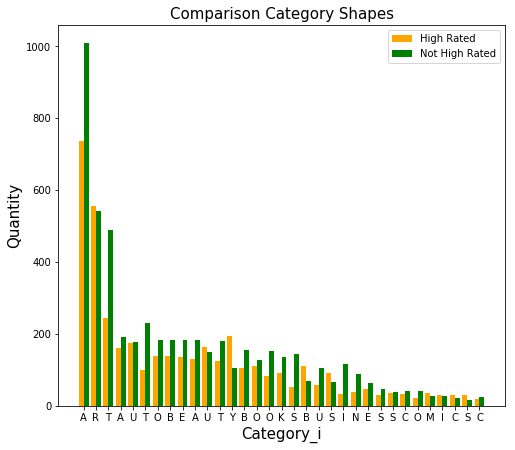

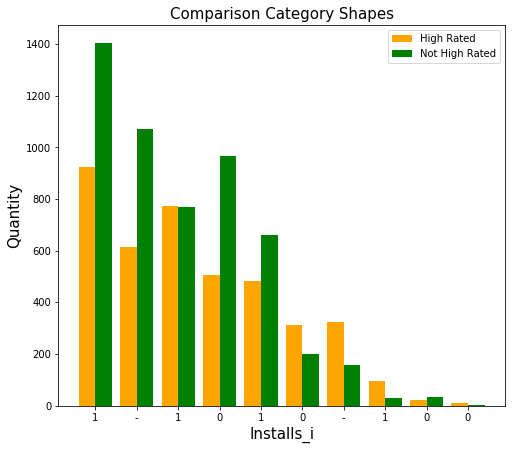

In [78]:
i = 0
def drawCompareGraphic(feature, title, ticklabels):
    global i
    shape_cap = d[feature].value_counts()
    shape_labels = shape_cap.axes[0].tolist()

    inde = np.arange(len(shape_labels))

    lowRatedShape = []
    highRatedShape = []

    for shape in shape_labels:
        quantity = len(d[d[feature] == shape].index)
        edibles = len(d[(d[feature] == shape) & (d['High_Rated'] == 1)].index)
        highRatedShape.append(edibles)
        lowRatedShape.append(quantity-edibles)

    ancho = 0.4
    fig, ax = plt.subplots(figsize=(8,7))
    ax.bar(inde, highRatedShape, ancho, color='orange')
    ax.bar(inde+ancho, lowRatedShape, ancho, color='green')

    ax.set_xlabel(feature, fontsize = 15)
    ax.set_ylabel('Quantity',fontsize=15)  
    ax.set_title(title,fontsize=15)
    ax.set_xticks(inde+ancho/2)
    ax.set_xticklabels(ticklabels, fontsize=10)
    ax.legend(['High Rated', 'Not High Rated'])
    i = i + 1
    plt.savefig('comparison' + str(i) + '.png')
    
    
drawCompareGraphic('Category_i', 'Comparison Category Shapes', ('ART' 'AUTO' 'BEAUTY' 'BOOKS'
                                                    'BUSINESS' 'COMICS' 'COMMUNICATION' 'DATING' 'EDUCATION' 'ENTERTAINMENT'
                                                    'EVENTS' 'FINANCE' 'FOOD' 'HEALTH' 'HOME'
                                                    'LIBRARIES' 'LIFESTYLE' 'GAME' 'FAMILY' 'MEDICAL' 'SOCIAL'
                                                    'SHOPPING' 'PHOTOGRAPHY' 'SPORTS' 'TRAVEL' 'TOOLS'
                                                    'PERSONALIZATION' 'PRODUCTIVITY' 'PARENTING' 'WEATHER' 'VIDEO'
                                                    'NEWS' 'MAPS'))

drawCompareGraphic('Installs_i', 'Comparison Category Shapes', ('1-10' '10-100' '100-1k' '1k-10k' '10k-100k' '100k-1M' 
                                                                '1M-10M' '10M-100M' '100M-1B'))

9360


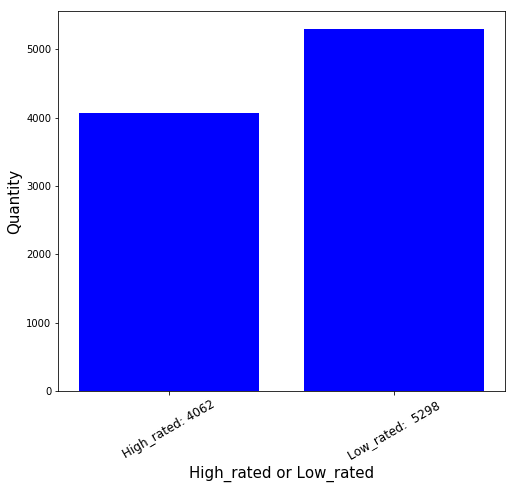

In [79]:
#Representamos la cantidad de muestras de ejmplo que son high_rated o low_rated a nivel gloval
print(len(d))
highRated = []
lowRated = []

for cl in d["High_Rated"]:
    if cl==0:
        lowRated.append(cl)
    else:
        highRated.append(cl)

xBars = ['High_rated: ' + str(len(highRated)), 'Low_rated:  ' + str(len(lowRated))]        
ancho = 0.8
fig, ax = plt.subplots(figsize=(8,7))
index = np.arange(len(xBars))
plt.bar(index, [len(highRated), len(lowRated)], ancho, color='blue')
plt.xlabel('High_rated or Low_rated', fontsize=15)
plt.ylabel('Quantity', fontsize=15)
plt.xticks(index, xBars, fontsize=12, rotation=30)
plt.savefig('High_rated and Low_rated.png')
#Mayor número de muestras comestibles que venenosas, como se puede observar en la gráfica

In [80]:
d.drop(labels = ['Category', 'Reviews', 'Size', 'Installs', 'Price'], axis = 1, inplace = True)

d.head()

,High_Rated,Category_i,Installs_i,Price_i,Reviews_i
0,0,0,4,0,2
1,0,0,5,0,2
2,1,0,6,0,4
3,1,0,7,0,5
4,0,0,5,0,2


In [81]:
labelEncode = preprocessing.LabelEncoder()

#YArr = d['High_Rated'].array
YArr = labelEncode.fit_transform(dataRate.values.ravel())

print(len(YArr))

9360


In [82]:
d.drop(labels = ['High_Rated'], axis = 1, inplace = True)

In [83]:
dataFeat = DataFrame(d)

#print(dataFeat)
XArr = pd.get_dummies(dataFeat.astype(str)).values

print(len(XArr))

9360


In [84]:
# ------------------------------
# Regresion Logistica
# ------------------------------

def RegresionLogistica(data):
    from scipy.optimize import fmin_tnc as tnc
    from matplotlib import pyplot as plt
    from sklearn.preprocessing import PolynomialFeatures as pf
    import sys

    learning_rate = 1.0
    POLY = 3

    #--------------------------------------------------
    
    def poli_f(X, grado):
        poly = pf(grado)
        return poly, poly.fit_transform(X)

    def J(theta, X, Y):
        m = np.shape(X)[0]
        n = np.shape(X)[1]
        theta = np.reshape(theta, (1, n))
        v1 = np.dot(np.transpose((np.log(g(np.dot(X, np.transpose(theta)))))), Y)
        v2 = np.dot(np.transpose((np.log(1 - g(np.dot(X, np.transpose(theta)))))), (1 - Y))
        v3 = (learning_rate/(2*m)) * np.sum(theta[1:]**2)
        return (((-1/m)*(v1 + v2)) + v3)

    def gradient(theta, X, Y):
        m = np.shape(X)[0]
        n = np.shape(X)[1]
        theta = np.reshape(theta, (1, n))
        var1 = np.transpose(X)
        var2  = g(np.dot(X, np.transpose(theta)))-Y
    
        theta = np.c_[[0], theta[:, 1:]]
        var3 = (learning_rate/m) * theta
        return ((1/m) * np.dot(var1, var2)) + np.transpose(var3)

    def g(z):
        return 1/(1 + np.exp(-z))

    def draw_data(X, Y):
        pos = np.where(Y == 0)[0] #vector with index of the Y = 1
        plt.scatter(X[pos, 0], X[pos, 1], marker='.', c='r')
        pos = np.where(Y == 1)[0].ravel() #vector with index of the Y = 1
        plt.scatter(X[pos, 0], X[pos, 1], marker='.', c='y')

    def draw_decision_boundary(theta, X, Y, poly):
        x0_min, x0_max = X[:,0].min(), X[:,0].max()
        x1_min, x1_max = X[:,1].min(), X[:,1].max()
        xx1, xx2 = np.meshgrid(np.linspace(x0_min, x0_max), np.linspace(x1_min, x1_max))
        
        sigm = g(poly.fit_transform(np.c_[ xx1.ravel(), xx2.ravel()]).dot(theta))
        sigm = sigm.reshape(xx1.shape)

        plt.contour(xx1, xx2, sigm, [0.5], linewidths = 1, colors = 'g')

    def draw(theta, X, Y, poly):
        plt.figure(figsize=(12,7))
        draw_data(X, Y)
        draw_decision_boundary(theta, X, Y, poly)
        plt.show()

    def load_csv_svm(file_name, features):
        dataFile = pd.read_csv(file_name, header = 0)

        dataFile = dataFile.fillna(0)
        y = dataFile['Rating'].array

        X = np.array([])
        X = np.reshape(X, (len(y), 0))
        for i in range(len(features)):
            X = np.c_[X, dataFile[features[i]].array]

        return X, y

    def load_Data(data, y_feat, features):
        #if y_feat == "Rating":
        #    data[y_feat] = data[y_feat].map(rating_bynary_trans)

        y = data[y_feat].array

        X = np.array([])
        X = np.reshape(X, (len(y), 0))
        for i in range(len(features)):
            X = np.c_[X, data[features[i]].array]
        return X, y
    
    #--------------------------------------------------
    
    #Evaluación de los resultados obtenidos en las predicciones con las thetas óptimas
    def evalua(thetas, X, y):
        thetasMat = np.matrix(thetas)   
        z = np.dot(thetasMat,X.transpose())
        resultados = sigmoide(z)
        resultados[resultados >= 0.5] = 1
        resultados[resultados < 0.5] = 0
        admitidosPred = sum(np.where(resultados == y)).shape[0]
        return (admitidosPred / len(y)) * 100

    def doIt(data):
        #Formato tabla que nos indica si en una posición hay un valor, con 0-1
        #XArr = pd.get_dummies(data).values
        #XArr = np.insert (XArr ,0, 1, axis = 1)

        #YArr = labelEncode.fit_transform(dataRating.values.ravel())

        X, y = load_Data(data, "High_Rated", ["Reviews_i", "Installs_i"])
        X = np.array(X)
        y = np.array(y)
        y = np.reshape(y, (np.shape(y)[0], 1))
        poly, X_poly = poli_f(X, POLY)
        theta = np.zeros([1, np.shape(X_poly)[1]], dtype=float)
        theta = tnc(func=J, x0=theta, fprime=gradient, args=(X_poly,y))[0]
        #theta_opt = theta[0]
        draw(theta, X, y, poly)
        
        #prediction = evalua(theta_opt, X, y)
        #models_times[0] = (prediction)
        #print(models_times)
        #print("PREDICTIONS RESULT:",prediction)
        
    doIt(data)

In [85]:
#RegresionLogistica(d)

m = len(YArr)

#La función sigmoide es la función h, la hipótesis
def sigmoide(value):
    s = 1/(1+np.exp(-value))
    return s

#FUNCIÓN DE COSTE
def coste(O, X, Y):
    H = sigmoide(np.dot(X,O))
    logH = np.log(H)
    logHT = logH.T
    logAux = np.log((1- H))
    logAuxT = logAux.T
    YT = Y.T
    suma = (-1/m)* (np.dot(YT, logH) + np.dot((1-YT), logAux))
    return suma
    
#FUNCIÓN DE GRADIENTE
def gradiente(O, X, Y):
    return (X.T.dot((sigmoide(X.dot(O))) - Y))/m

#FUNCIÓN DE COSTE REGULARIZADA (lambda)
def coste2(O, X, Y, lam):
    sol = (coste(O, X, Y) + (lam/(2*m))*(O**2).sum())
    return sol
   
#FUNCIÓN DE GRADIENTE REGULARIZADA (lambda)
def gradiente2(O, X, Y, lam):
    AuxO = np.hstack([np.zeros([1]), O[1:,]])
    return (((X.T.dot(sigmoide(X.dot(O))-Y))/m) + (lam/m)*O)

#---------------------------------------------

X = XArr.copy()
X = np.insert(X, 0, 1, axis = 1)

start = time.time()
thetas = np.ones(len(X[0]))
result = opt.fmin_tnc(func = coste2, x0 = thetas, fprime = gradiente2, args = (X, YArr, 0.1))
thetas_opt = result[0]
end = time.time()
print("EXE TIME:", end - start, "seconds")
print("OPT THETAS:\n", thetas_opt)


#Evaluación de los resultados obtenidos en las predicciones con las thetas óptimas
def evalua(thetas, X, y):
    thetasMat = np.matrix(thetas)   
    z = np.dot(thetasMat,X.transpose())
    resultados = sigmoide(z)
    resultados[resultados >= 0.5] = 1
    resultados[resultados < 0.5] = 0
    admitidosPred = sum(np.where(resultados == y)).shape[0]
    return (admitidosPred / len(y)) * 100
prediction = evalua(thetas_opt, X, YArr)
models_times[0] = (prediction)
print(models_times)
print("PREDICTIONS RESULT:",prediction)

FEATURES SHAPE: (9360, 54)
FEATURES SHAPE WITH 1s column: (9360, 55)
EXECUTION TIME: 0.8187308311462402 seconds
OPT THETAS:
 [ 0.56206682  0.82940503  0.29298238  0.97976949 -0.02210515  0.02646253
  0.79315911  0.06364795 -0.06564551 -0.01070019 -0.18966082 -0.12283285
  0.27563916  0.44808053 -0.48906635 -0.02090765 -0.32262933 -0.20363878
 -0.12579121 -0.45193963  0.19429963 -0.09043477  1.25459409  0.07830859
  0.79151708 -0.4041391  -0.36388315 -0.62753338 -0.09459183  0.42384809
 -1.07517431 -0.83297663  0.62789929 -1.17768531  3.74115627  2.96409951
  2.14887976  1.10401729  0.28741171 -0.49778822 -1.5155255  -2.08955188
 -2.29328377 -3.34135545  0.13054435  0.37149712  0.12801226 -2.42803168
 -2.10714671 -1.62689719 -0.70841914  0.50866853  1.60527857  2.78131575
  2.98162319]
[66.29273504  1.          2.          3.        ]
PREDICTIONS RESULT: 66.29273504273505


## Red Neuronal

In [98]:
# ------------------------------
# Red Neuronal
# ------------------------------

from scipy.optimize import minimize as sciMin
from scipy.io import loadmat

lambda_ = 1
    
def load_csv(dataFile):
    y = dataFile['High_Rated'].array
    dataFile = dataFile.drop(['High_Rated'], axis = 1).values
    return dataFile, y
    
def g(z):
    """
    1/ 1 + e ^ (-0^T * x)
    """
    return 1/(1 + np.exp(-z))
    
def derivada_de_G(z):
    result = g(z) * (1 - g(z))
    return result
    
def pesos_aleat(L_in, L_out):
    pesos = np.random.uniform(-0.12, 0.12, (L_out, 1+L_in))

    return pesos
    
def transform_y(y, num_etiquetas):
    #y = np.reshape(y, (np.shape(y)[0], 1))
    mask = np.empty((num_etiquetas, np.shape(y)[0]), dtype=bool)
    for i in range( num_etiquetas):
        mask[i, :] = ((y[:, 0] + num_etiquetas - 1) % num_etiquetas == i) 
        #codificado con el numero 1 en la posicion 0 y el numero 0 en la posicion 9

    mask = mask * 1

    return np.transpose(mask)
    
def J(X, y, a3, num_etiquetas, theta1, theta2):
    m = np.shape(X)[0]
    aux1 = -y * (np.log(a3))
    aux2 = (1 - y) * (np.log(1 - a3))
    aux3 = aux1 - aux2
    aux4 = np.sum(theta1**2) + np.sum(theta2**2)
    #print (aux4)
    return (1/m) * np.sum(aux3) + (lambda_/(2*m)) * aux4
    
def forward_propagate(X, theta1, theta2):
    m = X.shape[0]
    a1 = np.hstack([np.ones([m, 1]), X])
    z2 = np.dot(a1, theta1.T)
    a2 = np.hstack([np.ones([m, 1]), g(z2)])
    z3 = np.dot(a2, theta2.T)
    h = g(z3)
    return a1, z2, a2, z3, h
    
def add_column_left_of_matrix(matrix):
        new_matrix = np.hstack([np.ones([np.shape(matrix)[0], 1]), matrix]) #convention in linear regr
        return new_matrix
    
def propagation(a1, theta1, theta2):
    a1 = add_column_left_of_matrix(a1)
    a2 = g(np.dot(a1, np.transpose(theta1)))      
    a2 = add_column_left_of_matrix(a2)
    a3 = g(np.dot(a2, np.transpose(theta2)))

    return a1, a2, a3

    
def backdrop(params_rn, num_entradas, num_ocultas, num_etiquetas, X, y, reg):
    """
    return coste y gradiente de una red neuronal de dos capas
    """
    theta1 = np.reshape(params_rn[:num_ocultas*(num_entradas + 1)], 
        (num_ocultas, (num_entradas + 1)))
    theta2 = np.reshape(params_rn[num_ocultas*(num_entradas + 1):], 
        (num_etiquetas, (num_ocultas + 1)))

    #--------------------PASO1---------------------------------------
    
    a1, a2, a3 = propagation(X, theta1, theta2)
    m = np.shape(X)[0]
    delta_3 = a3 - y # (5000, 10)
    #--------------------PASO2---------------------------------------
    #delta_3 = a3 - y # (5000, 10)
    delta_matrix_1 = np.zeros(np.shape(theta1))
    delta_matrix_2 = np.zeros(np.shape(theta2))

    aux1 = np.dot(delta_3, theta2) #(5000, 26)
    aux2 = add_column_left_of_matrix(derivada_de_G(np.dot(a1, np.transpose(theta1))))
    delta_2 = aux1 * aux2 #(5000, 26)
    delta_2 = np.delete(delta_2, [0], axis=1) #(5000, 25)

    # #--------------------PASO4---------------------------------------

    delta_matrix_1 = delta_matrix_1 + np.transpose(np.dot(np.transpose(a1), delta_2)) #(25, 401)
    delta_matrix_2 = delta_matrix_2 + np.transpose(np.dot(np.transpose(a2), delta_3)) #(10, 26)
    #--------------------PASO6---------------------------------------
    delta_matrix_1 = (1/m) * delta_matrix_1
    delta_matrix_1[:, 1:] = delta_matrix_1[:, 1:] + (reg/m) * theta1[:, 1:] 

    delta_matrix_2 = (1/m) * delta_matrix_2
    delta_matrix_2[:, 1:] = delta_matrix_2[:, 1:] + (reg/m) * theta2[:, 1:] 


    cost = J(X, y, a3, num_etiquetas, theta1, theta2)
    gradient = np.concatenate((np.ravel(delta_matrix_1), np.ravel(delta_matrix_2)))

    return cost, gradient
    
def checkLearned(y, outputLayer):     
    checker = (outputLayer > 0.7) 
    count = np.size(np.where(checker[:, 0] == y[:, 0])) 
    fin = count/np.shape(y)[0] * 100
    return fin, checker

def RedNeuronal(data):
    #X, y = load_csv(data)
    #X = np.array(X)
    #y = np.array(y)
    #y = np.reshape(y, (np.shape(y)[0], 1))
        
    X = XArr.copy()
    y = YArr.copy()
    y = np.reshape(y, (np.shape(y)[0], 1))

    # ------------------------------
    legendPos = np.where(y == 1)
    legendX = X[legendPos[0]]

    normiePos = np.where(y == 0)
    normieX = X[normiePos[0]]
    # ------------------------------

    num_entradas = np.shape(X)[1]
    num_ocultas = 25
    num_etiquetas = 1

    theta1 = pesos_aleat(num_entradas, num_ocultas)
    theta2 = pesos_aleat(num_ocultas, num_etiquetas)

    theta_vector = np.concatenate((np.ravel(theta1), np.ravel(theta2)))

    thetas = sciMin(fun=backdrop, x0=theta_vector,
    args=(num_entradas, num_ocultas, num_etiquetas, X, y, lambda_),
    method='TNC', jac=True,
    options={'maxiter': 70}).x

    theta1 = np.reshape(thetas[:num_ocultas*(num_entradas + 1)], 
            (num_ocultas, (num_entradas + 1)))
    theta2 = np.reshape(thetas[num_ocultas*(num_entradas + 1):], 
            (num_etiquetas, (num_ocultas + 1)))
    a, c = checkLearned(y, forward_propagate(X, theta1, theta2)[4])

    #b = c
    
    print("Precision de la red neuronal: " + str(a) + " %")

In [99]:
RedNeuronal(d)

Precision de la red neuronal: 61.59188034188035 %
